<div style="background-color:rgb(255, 250, 250); padding:5px; padding-left: 1em; padding-right: 1em;">

<h1 id="tutorial1" style="text-align: justify">LC-MS Metabolomics Data Processing</h1>
<p style="text-align: justify">
</div>
<p style="text-align: justify">The study used in this tutorial has been previously published as an open access article <a href="https://www.pnas.org/content/113/16/4252">Chaleckis et al. (2016)</a>, 
in PNAS, and the datasets are available on MetaboLights under the ID <a href="https://www.ebi.ac.uk/metabolights/MTBLS265/descriptors">MTBLS265</a>.</p>
</div></div>


<ul>

### Summary

<li style="text-align: justify">Peaks detection</li>

<li style="text-align: justify">Peaks grouping</li>

<li style="text-align: justify">Peaks alignment</li>

<li style="text-align: justify">Filling missing features</li>

<li style="text-align: justify">Peak visualisation and metabolites annotation</li>

<ul>

<p style="text-align: justify">The data processing in this tutorial is done using <a href="https://www.bioconductor.org/packages/release/bioc/html/xcms.html">the XCMS package</a>, 
more information on the XCMS package is available in the paper by <a href="https://pubs.acs.org/doi/10.1021/ac051437y">Smith et al. (2006)</a>, an online version of XCMS is also available: <a href="https://xcmsonline.scripps.edu/landing_page.php?pgcontent=mainPage">XCMS Online</a>.</p>
</div></div>

<p style="text-align: justify">This notebook is based on the R language, multiple libraries such as XCMS, mzR, msdata are available via <a href="https://www.bioconductor.org/">Bioconductor</a> <br>
</p>

In [12]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] fr_FR.UTF-8/fr_FR.UTF-8/fr_FR.UTF-8/C/fr_FR.UTF-8/fr_FR.UTF-8

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] xcms_3.10.2                 MSnbase_2.14.2             
 [3] ProtGenerics_1.20.0         BiocParallel_1.22.0        
 [5] scales_1.1.1                SummarizedExperiment_1.18.2
 [7] DelayedArray_0.16.0         MatrixGenerics_1.2.0       
 [9] matrixStats_0.57.0          Matrix_1.2-18              
[11] GenomicRanges_1.40.0        GenomeInfoDb_1.24.2        
[13] IRanges_2.24.0              S4Vectors_0.28.0           
[15] pheatmap_1.0.12             magrittr_2.

In [2]:
#Import the libraries needed for the data processing
library(xcms)
library(msdata)
library(multtest)
library(mzR)
library(RColorBrewer)
library(pander)
library(magrittr)
library(pheatmap)
library(BiocGenerics)
library(Biobase)
library(parallel)
library(stats)
library(SummarizedExperiment)
library(scales)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with


In [3]:
# Import dataset files location (where to find the MS files in mzML format)
    # Here using MTBLS265: Individual variability in human blood metabolites identifies age-related differences (30 persons, whole blood data).
#files = list.files("A:/IARC/Data/MTBLS265/sample", recursive = TRUE, full.names = TRUE)
files = list.files("/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361", recursive = TRUE, full.names = TRUE)

In [4]:
files

[1] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person01_blood_youth_POS.mzML"
[2] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person02_blood_youth_POS.mzML"
[3] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person03_blood_youth_POS.mzML"
[4] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person04_blood_youth_POS.mzML"
[5] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person05_blood_elder_POS.mzML"
[6] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person06_blood_elder_POS.mzML"
[7] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person07_blood_elder_POS.mzML"
[8] "/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person08_blood_elder_POS.mzML"

## Peak detection

In [5]:
#Constructor For XcmsSet Objects Which Finds Peaks In NetCDF/MzXML Files
    # DESCRIPTION: Find peaks in batch mode and pre-sorts files from subdirectories into different classes for grouping
    # METHOD: MatchedFilter methods to find peaks in the extracted chromatographic time domain of the profile matrix
xset = xcmsSet(files, method= "matchedFilter")

In [6]:
# XCMSset objects characteristics
xset
print("__________________________________________________________________")

An "xcmsSet" object with 8 samples

Time range: 161.9-1779.9 seconds (2.7-29.7 minutes)
Mass range: 102.0534-991.1106 m/z
Peaks: 12435 (about 1554 per sample)
Peak Groups: 0 
Sample classes: wetransfer-a21361 

Feature detection:
 o Peak picking performed on MS1.
Profile settings: method = bin
                  step = 0.1

Memory usage: 1.35 MB

[1] "__________________________________________________________________"


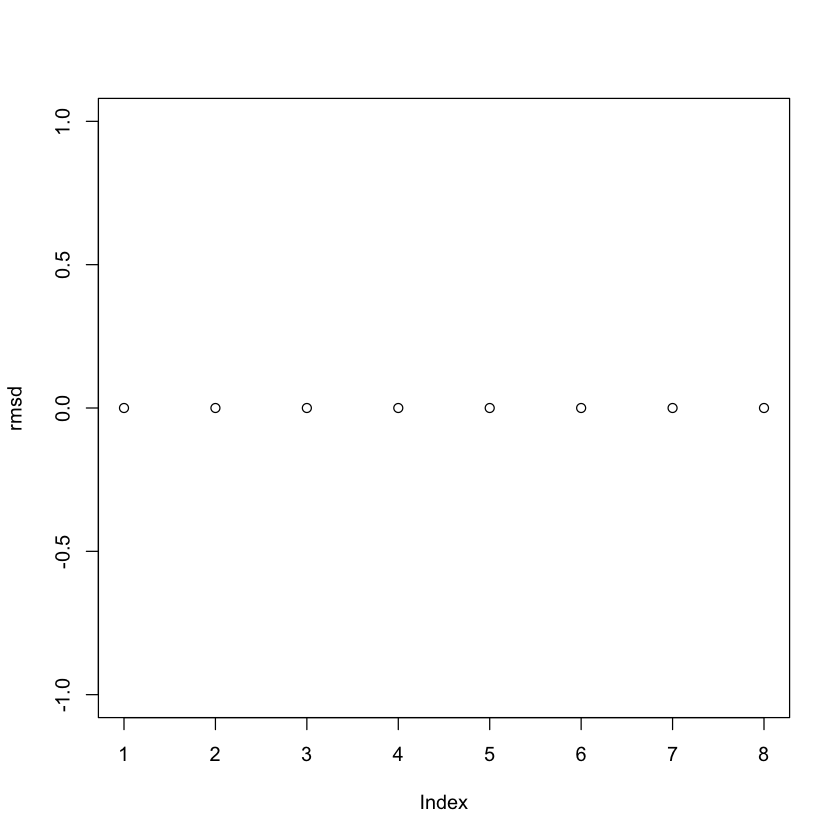

In [7]:
#Calculation and plot of root mean squared distance (RMSD) between RT before and after correction
#xcms set fait une correction automatique
#pas de différence entre avant aprés correction automatique ( 0) car données bonnes
# Plot of XCMSset 1
rmsd = sapply(1:length(xset@rt$corrected),function(x) {sqrt(sum((xset@rt$raw[[x]]-xset@rt$corrected[[x]])**2))})
plot(rmsd)

## Peak grouping

In [8]:
#Grouping peaks from different samples
#group les peaks des différents éxchantillons , les peaks qui matchent
#ex: pattern d'isotope
#groupe les features , plusieurs isotopes d'une même molécules
#plusieurs échantillons ont donné les mêmes pics , et viennent d'une même features ( en gros même mtabolites)
# mais attention métabolites et features peuvent être différent 

xsetgroup = group(xset)

Processing 7114 mz slices ... 
OK



In [9]:
xsetgroup

An "xcmsSet" object with 8 samples

Time range: 161.9-1779.9 seconds (2.7-29.7 minutes)
Mass range: 102.0534-991.1106 m/z
Peaks: 12435 (about 1554 per sample)
Peak Groups: 1434 
Sample classes: wetransfer-a21361 

Feature detection:
 o Peak picking performed on MS1.
Profile settings: method = bin
                  step = 0.1

Memory usage: 1.61 MB

## Peak alignment

Performing retention time correction using 742 peak groups.



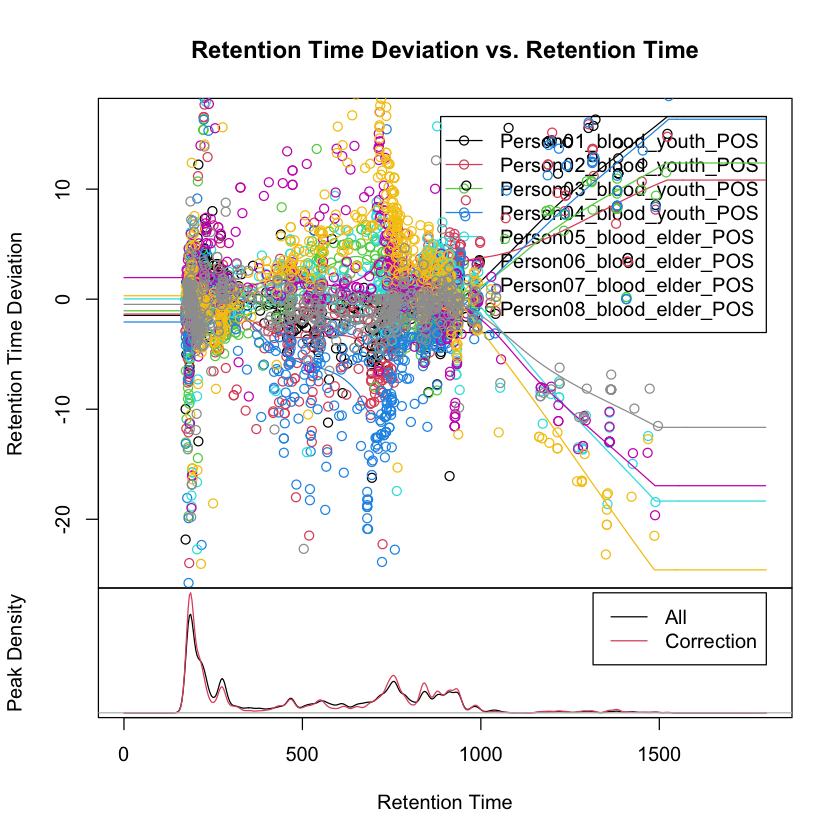

In [10]:
#Retention time correction with symmetric method with peak grouping and result visualisation
xsg = retcor(xsetgroup,family = "symmetric", smooth = c("loess","linear"),plottype = "mdevden")
#RTD bonne à 0 
#prendre que de 500 à 1100 secondes 

In [11]:
#entre au dessus et en dessous 
# Deux méthodes differentes
#obiwrap se fout des groupes, methodes obiwrap fait en blind, 

In [12]:
#Retention time correction with Obiwarp and visualize the result
xsg_retcor = retcor(xset, method="obiwarp", profStep=0.1, distFunc= "cov", plottype=c("none","deviation"))

center sample:  Person07_blood_elder_POS 
Processing: Person01_blood_youth_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK

Create profile matrix with method 'bin' and step 0.1 ... 
OK



Person02_blood_youth_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK



Person03_blood_youth_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK



Person04_blood_youth_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK



Person05_blood_elder_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK



Person06_blood_elder_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK



Person08_blood_elder_POS  

Create profile matrix with method 'bin' and step 0.1 ... 
OK



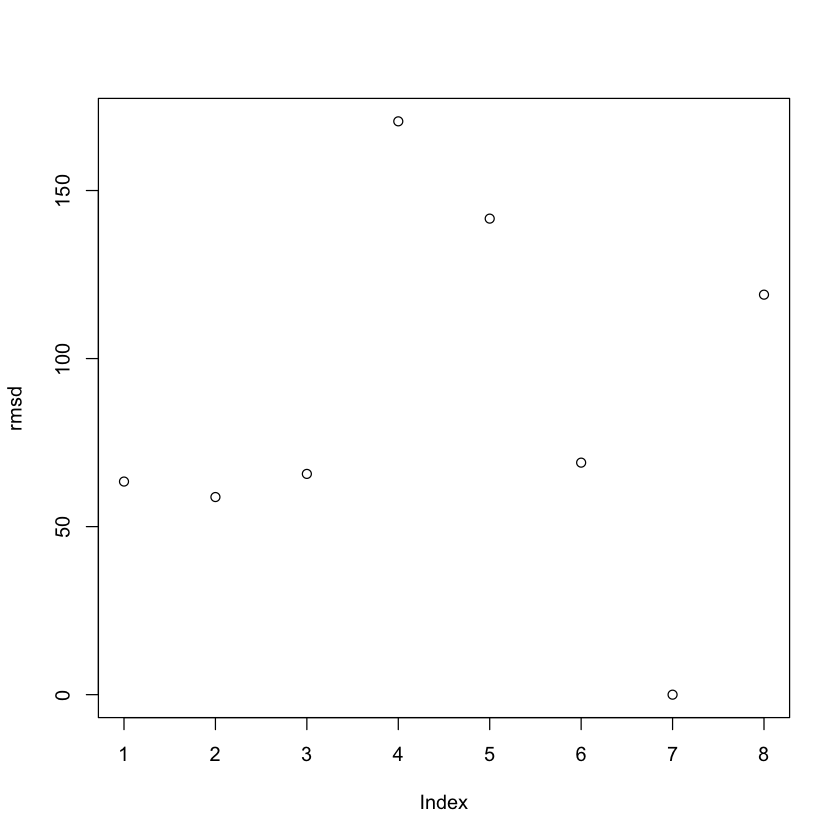

In [26]:
# Root mean square deviation for RT corrected data and visualisation
rmsd = sapply(1:length(xsg_retcor@rt$corrected),function(x) {sqrt(sum((xsg_retcor@rt$raw[[x]]-xsg_retcor@rt$corrected[[x]])**2))})
plot(rmsd)


In [27]:
# Grouping peaks after RT correction with ObiWarp
xsg_retcor_group = group(xsg_retcor,bw=10)

Processing 7114 mz slices ... 
OK



## Filling missing features

In [28]:
# Filling back missing peaks in the dataset
#For each sample, identify peak groups where that sample is not represented. For each of those peak groups, 
#integrate the signal in the region of that peak group and create a new peak.
xsg_retcor_group_fill = fillPeaks(xsg_retcor_group, nSlaves=2,expand.mz=1,expand.rt=1)

Use of argument 'nSlaves' is deprecated, please use 'BPPARAM' instead.

/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person03_blood_youth_POS.mzML 
method:  bin 
step:  0.1 

/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person05_blood_elder_POS.mzML 
method:  bin 
step:  0.1 

/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person06_blood_elder_POS.mzML 
method:  bin 
step:  0.1 

/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person04_blood_youth_POS.mzML 
method:  bin 
step:  0.1 

/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person01_blood_youth_POS.mzML 
method:  bin 
step:  0.1 
/Users/aurorebonnal/Documents/SkyDrive/Documents/insa/5BIM/genomique médicale/projet/wetransfer-a21361/Person02_blood_youth_

## Output

In [29]:
# Extract peak table from the processed data
peaks = peakTable(xsg_retcor_group_fill)

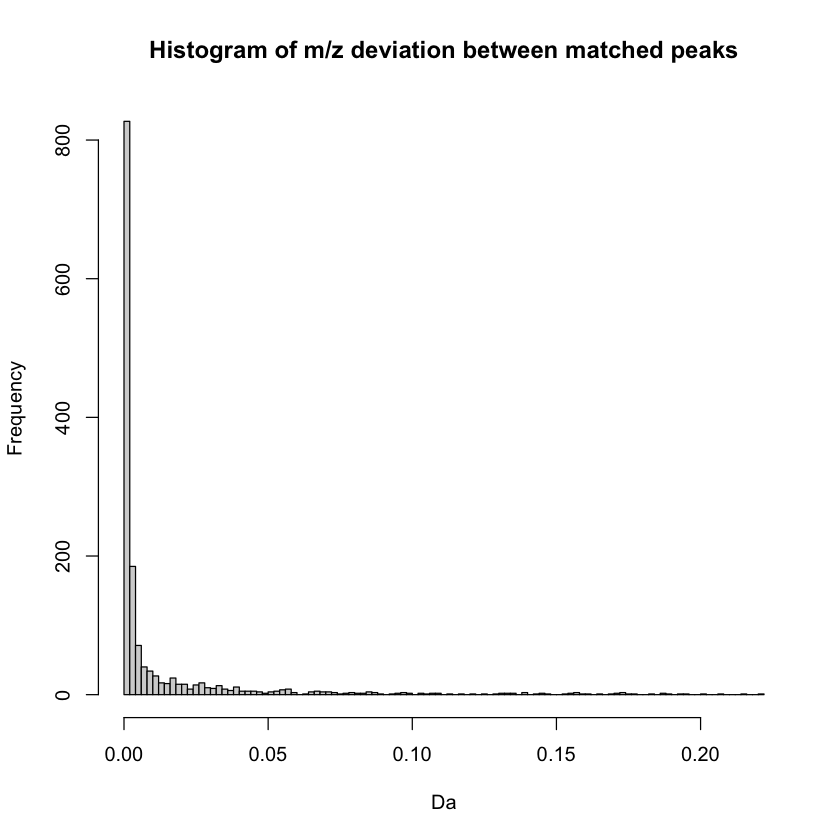

In [30]:
# Histogram visualisation of the m/z deviation between the matched peaks
hist(peaks$mzmax-peaks$mzmin,100, xlab = "Da",
     main="Histogram of m/z deviation between matched peaks")

#

## Peak visualisation & metabolites annotation

In [31]:
# Build a XCMSRaw object
    #xset : XcmsSet Objects
    # Reads raw mzMl files into a xcmsRaw object
    # Transfor data into profile mode for data plotting and exploration
xraw = xcmsRaw(xset@filepaths[1])

Create profile matrix with method 'bin' and step 1 ... 
OK



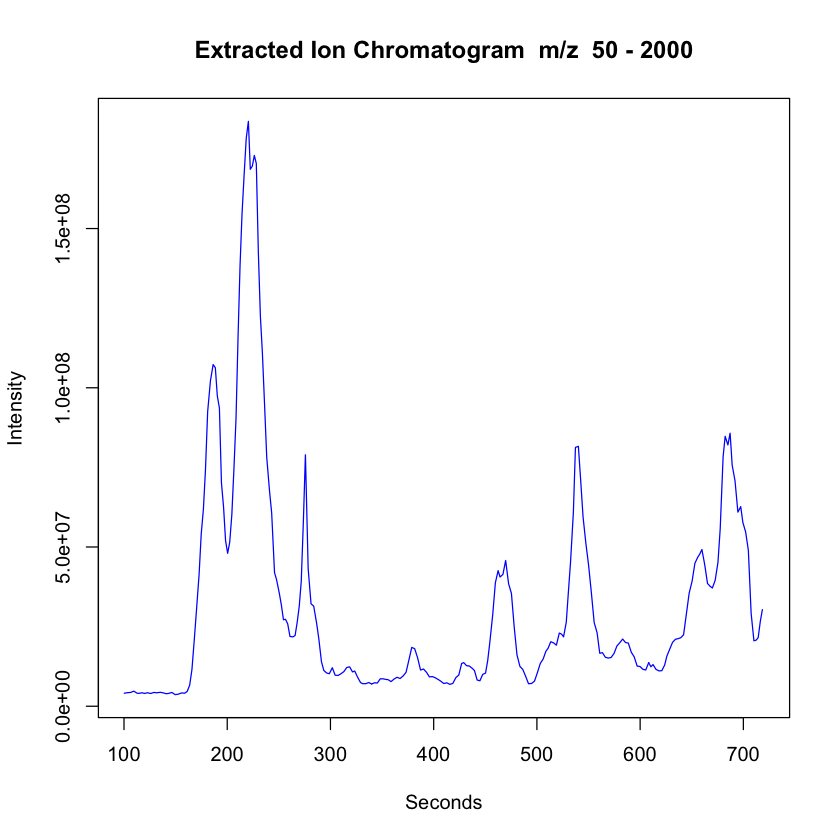

In [32]:
# Visualisation of the Extracted Ion Chromatogram for the different corrections methods used to build the xset 
plotEIC(xraw,mzrange=c(50,2000),rtrange=c(100,12*60), col="blue")
#An extracted ion chromatogram is a plot of the signal intensity at one or more selected m/z values in a
#series of mass spectra that are recorded as a function of chromatographic retention tim.

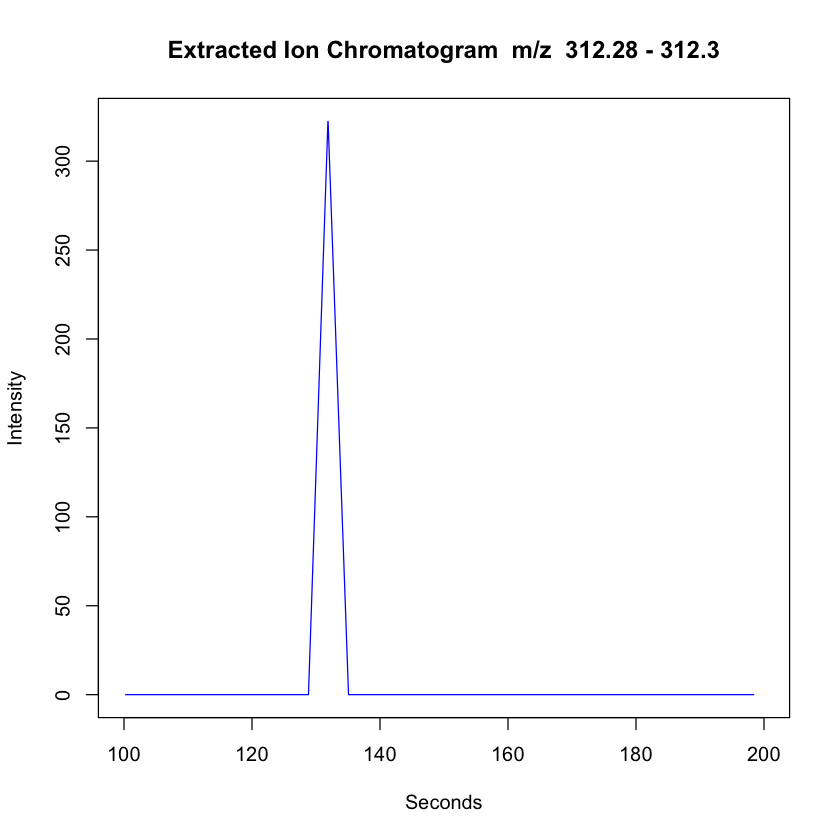

In [33]:
# Get EIC (Extracted Ion Chromatogram) for the metabolite dimethyl-guanosine
# Mass for dimethyl-guanosine 311.29
# Find the extracted ion chromatogram (EIC) for the adduct M+H (add the mass of H to the mass)

plotEIC(xraw,mzrange=c(312.28,312.30),#mzrange is the parameter range within which the mass detected by the MS is (mass after ionisation)
        rtrange=c(100,200), col="blue") #rtrange is the parameter range for the time range in which the metabolite is eluted on the LC column 

In [34]:
library(ggplot2)

# Save data for waterfall plot Sample 1 is for young and sample 2 for old
xraw_young = xcmsRaw(xset@filepaths[1])
xraw_old = xcmsRaw(xset@filepaths[5])

ova<- getEIC(xraw_young, mzrange=cbind(312.28,312.30))
ova<- as.matrix(ova@eic$xcmsRaw[[1]]) ## Change the file to a matrix

ovb<- getEIC(xraw_old, mzrange=cbind(312.28,312.30))
ovb<- as.matrix(ovb@eic$xcmsRaw[[1]])


x1<- ova[,1]
z1<- ova[,2]
y1<- 2

x2<- ovb[,1]
z2<- ovb[,2]
y2<- 1


xyz1<- data.frame(x1,y1, z1)
xyz2<- data.frame(x2,y2, z2)



Create profile matrix with method 'bin' and step 1 ... 
OK

Create profile matrix with method 'bin' and step 1 ... 
OK



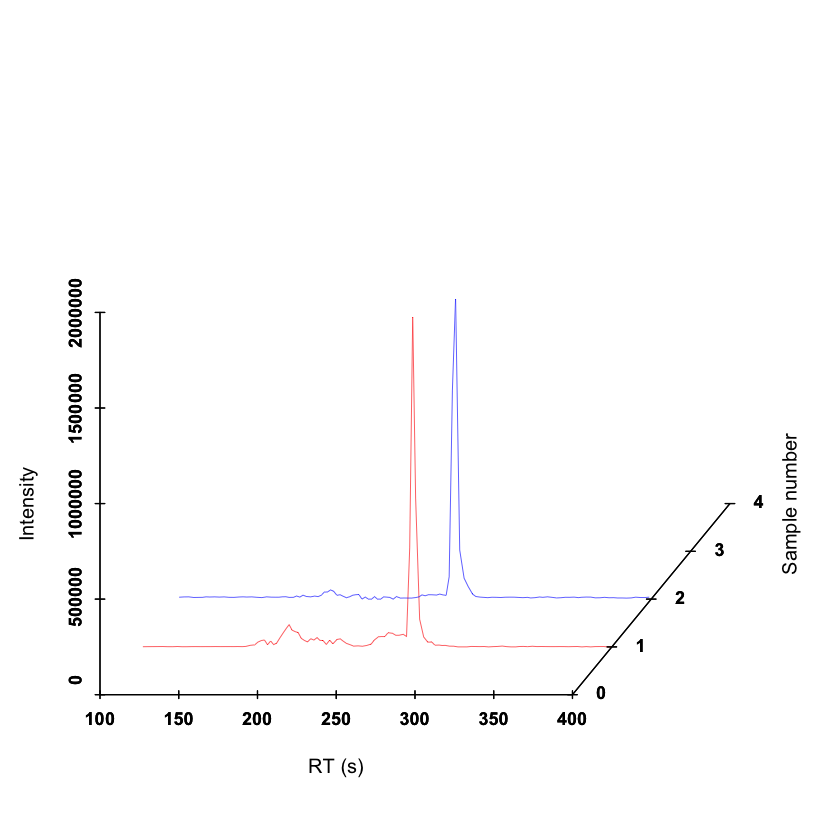

In [35]:
## 3D plot 

library(scatterplot3d)

with(xyz2, {
    scatterplot3d(x2, y2,  z2,  type= "l", color = "red",xlim= c(100,400), ylim= c(0,4),
                  xlab="", ylab= "", zlab= "", grid=F, angle= 45, box=F, cex.axis = 0.9, font.lab = 2, lwd=0.5)
  })
  
  par(new=T )
  
  with(xyz1, {
    scatterplot3d(x1, y1, z1, type= "l", color = "blue", xlim= c(100,400),ylim= c(0,4),
                  xlab="RT (s)", ylab= "Sample number", zlab= "Intensity", grid = F, angle= 45, box= F, cex.axis = 0.9, font.lab = 2, lwd=0.5)
  })

#############################################################################################################################################################################

## Exercise 1: 
#### Find the EIC peak for the citrulline metabolite?
**What is the retention time range of this metabolite?**
<br>

*Tips:* 
* Look for the M+H adduct 
* Use exact mass
* Work with a 5ppm resolution (0.005 m/z)

## Exercice 2
This mass corresponds to the M+H adducts (<10ppm accuracy) of a metabolite found in these samples: ***132.076***
* This metabolite has been found to be linked to metabolic reactions in the human metabolic network simulating kidney failure
* Furthermore this metabolite is identified as an amino-acids. 

**Using the information above and the <a href="https://hmdb.ca/spectra/ms/search">HMDB database</a> find which metabolite is it and plot its EIC**

## Exercice 3
**1)** Can you find the M+H, M+Na, and M+NH4 adducts (use a 0.1m/z accuracy for your mass range) of ***pantothenate*** ? <br>
    What do you notice with the different adducts peaks? <br>
**2)** Now do the same thing but with a 0.001 m/z accuracy? <br>
    Can you explain the difference of EIC between the previous peaks in 1) ? <br>
**3)** What is the adduct with the highest intensity?<br>

Tips: 
Don't hesitate to zoom in the peaks using RT range (this metabolite elutes around 400 seconds) + it's possible that a peak does not exist as sometimes certain adducts do not form or are not detected if in very low quantities

In [34]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18362)

Matrix products: default

locale:
[1] LC_COLLATE=English_Europe.1252  LC_CTYPE=English_Europe.1252   
[3] LC_MONETARY=English_Europe.1252 LC_NUMERIC=C                   
[5] LC_TIME=English_Europe.1252    

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] pheatmap_1.0.12      magrittr_1.5         pander_0.6.3        
 [4] RColorBrewer_1.1-2   multtest_2.42.0      msdata_0.26.0       
 [7] xcms_3.8.2           MSnbase_2.12.0       ProtGenerics_1.18.0 
[10] S4Vectors_0.24.4     mzR_2.20.0           Rcpp_1.0.5          
[13] BiocParallel_1.20.1  Biobase_2.46.0       BiocGenerics_0.32.0 
[16] scatterplot3d_0.3-41 ggplot2_3.3.2       

loaded via a namespace (and not attached):
 [1] vsn_3.54.0             jsonlite_1.7.0         splines_3.6.3         
 [4] foreach_1.5.0      